## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Libraries**

In [ ]:
%pip install nibabel
%pip install tensorflow

## Import Libraries

In [ ]:
import re
import os
import shutil
import numpy as np
import nibabel as nib

from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate


## Organize Date ( Folders , Files ...)
**in a new isolated directory cnn_vessels**

In [ ]:
# source_folder = '/content/drive/MyDrive/vessels/nnUNet/nnunetv2/nnUNet_raw/Dataset101_HepVes/labelsTs'
# destination_folder = '/content/drive/MyDrive/cnn_vessels/labelsTs'

# # List all files in the source folder
# files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

# # Sort the files alphabetically
# files.sort()

# # Copy the first 260 files to the destination folder
# for file in files[:42]:
#     source_file_path = os.path.join(source_folder, file)
#     destination_file_path = os.path.join(destination_folder, file)
#     shutil.copy(source_file_path, destination_file_path)


In [ ]:

# labels_dir = '/content/drive/MyDrive/cnn_vessels/imagesTr_npz'

# pattern_to_remove = '0'

# label_files = os.listdir(labels_dir)

# for label_file in label_files:
#    if label_file.endswith('.npz'):
#        base_name = label_file[:-7]
#        extension = '.npz'
#    else:
#        print(f"Skipping unknown file type: {label_file}")
#        continue

#    if pattern_to_remove in base_name:
#        # Create a new base name by replacing the pattern with an empty string
#        new_base_name = base_name.replace(pattern_to_remove, '')
#        new_label_file = new_base_name + extension

#        current_label_path = os.path.join(labels_dir, label_file)
#        new_label_path = os.path.join(labels_dir, new_label_file)

#        os.rename(current_label_path, new_label_path)
#        print(f'Renamed "{label_file}" to "{new_label_file}"')
#    else:
#        print(f"No pattern found in {label_file}, skipping rename.")


In [ ]:
# # Define source and destination folders
# source_folder = '/content/drive/MyDrive/vessels/nnUNet/nnunetv2/nnUNet_preprocessed_test/Dataset101_HepVes/nnUNetPlans_3d_lowres'
# destination_folder = '/content/drive/MyDrive/cnn_vessels/imagesTr_npz'

# # Create destination folder if it doesn't exist
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # Iterate through files in the source folder
# for filename in os.listdir(source_folder):
#     # Check if the filename matches the desired pattern
#     if re.match(r'hepaticvessel_\d{3}_0000_0000_0000_0000\.npz', filename) and filename.endswith('.npz'):
#         # Construct paths for source and destination files
#         source_file = os.path.join(source_folder, filename)
#         destination_file = os.path.join(destination_folder, filename)

#         # Copy file from source to destination
#         shutil.copyfile(source_file, destination_file)
#         print(f'Copied file: {filename}')


Copied file: hepaticvessel_040_0000_0000_0000_0000.npz
Copied file: hepaticvessel_039_0000_0000_0000_0000.npz
Copied file: hepaticvessel_032_0000_0000_0000_0000.npz
Copied file: hepaticvessel_031_0000_0000_0000_0000.npz
Copied file: hepaticvessel_042_0000_0000_0000_0000.npz
Copied file: hepaticvessel_044_0000_0000_0000_0000.npz
Copied file: hepaticvessel_046_0000_0000_0000_0000.npz
Copied file: hepaticvessel_049_0000_0000_0000_0000.npz
Copied file: hepaticvessel_051_0000_0000_0000_0000.npz
Copied file: hepaticvessel_050_0000_0000_0000_0000.npz
Copied file: hepaticvessel_052_0000_0000_0000_0000.npz
Copied file: hepaticvessel_057_0000_0000_0000_0000.npz
Copied file: hepaticvessel_058_0000_0000_0000_0000.npz
Copied file: hepaticvessel_053_0000_0000_0000_0000.npz
Copied file: hepaticvessel_033_0000_0000_0000_0000.npz
Copied file: hepaticvessel_059_0000_0000_0000_0000.npz
Copied file: hepaticvessel_061_0000_0000_0000_0000.npz
Copied file: hepaticvessel_062_0000_0000_0000_0000.npz
Copied fil

## loading the data and align them crosponding to their labels

In [ ]:
# Define function to load and resize NIfTI images and labels
def load_and_resize_nifti_data(image_folder, label_folder, target_shape=(128, 128, 128)):
    images = []
    labels = []
    for img_name in os.listdir(image_folder):
        if not img_name.endswith('.nii.gz'):
            continue  # Skip files that are not NIfTI images
        img_path = os.path.join(image_folder, img_name)
        label_path = os.path.join(label_folder, img_name)

        # Load image
        img = nib.load(img_path)
        img_data = img.get_fdata()

        # Resize image to target shape
        img_resized = resize(img_data, target_shape, anti_aliasing=True, preserve_range=True)

        # Pad image if necessary
        pad_width = [(0, max(0, target_shape[i] - img_resized.shape[i])) for i in range(3)]
        if any(pad_width):
            img_padded = np.pad(img_resized, pad_width, mode='constant')
        else:
            img_padded = img_resized

        images.append(img_padded)

        # Load label
        label = nib.load(label_path)
        label_data = label.get_fdata()

        # Resize label to target shape
        label_resized = resize(label_data, target_shape, anti_aliasing=False, preserve_range=True)  # No anti-aliasing for labels

        # Pad label if necessary
        pad_width = [(0, max(0, target_shape[i] - label_resized.shape[i])) for i in range(3)]
        if any(pad_width):
            label_padded = np.pad(label_resized, pad_width, mode='constant')
        else:
            label_padded = label_resized

        labels.append(label_padded)

    return np.array(images), np.array(labels)

# Define paths to your NIfTI image and label folders
train_image_folder = '/content/drive/MyDrive/cnn_vessels/imagesTr'
train_label_folder = '/content/drive/MyDrive/cnn_vessels/labelsTr'
test_image_folder = '/content/drive/MyDrive/cnn_vessels/imagesTs'
test_label_folder = '/content/drive/MyDrive/cnn_vessels/labelsTs'

# Define target shape for resizing
target_shape = (256, 256, 256)  # Adjust target shape as needed

# Load and resize training data
train_images, train_labels = load_and_resize_nifti_data(train_image_folder, train_label_folder, target_shape)

# Load and resize testing data
test_images, test_labels = load_and_resize_nifti_data(test_image_folder, test_label_folder, target_shape)


## Visualization

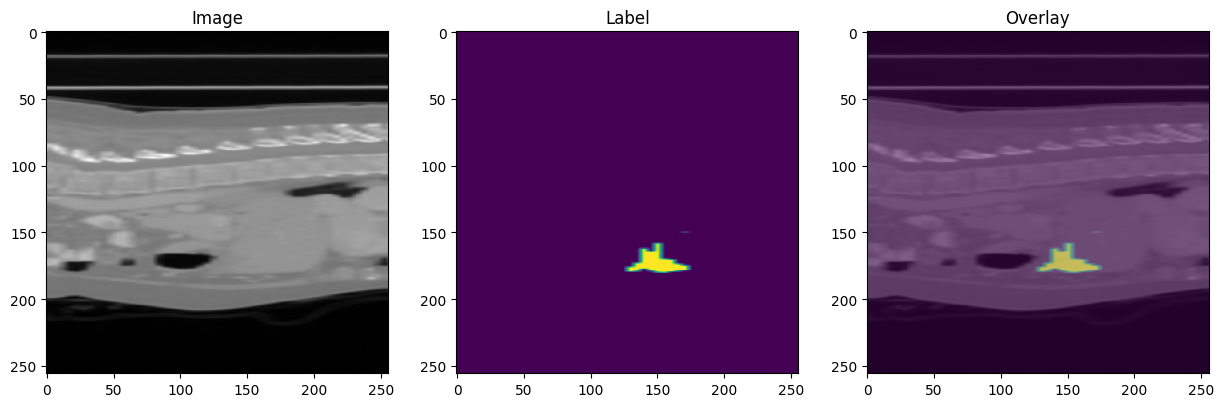

In [ ]:
# Function to visualize a random sample image and its label
def visualize_random_sample(images, labels):
    # Choose a random index
    idx = np.random.randint(0, len(images))

    # Extract the image and label for the chosen index
    image = images[idx]
    label = labels[idx]

    # Plotting the central slice for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image slice
    axes[0].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Image')

    # Plot label slice
    axes[1].imshow(label[label.shape[0] // 2, :, :], cmap='viridis')
    axes[1].set_title('Label')

    # Plot overlay of label on image
    axes[2].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[2].imshow(label[label.shape[0] // 2, :, :], alpha=0.5, cmap='viridis')
    axes[2].set_title('Overlay')

    plt.show()

# Visualize a random sample
visualize_random_sample(train_images, train_labels)


## Intensity Normalization

In [ ]:
def normalize_intensity(images, labels):
    # Calculate mean and standard deviation of intensities
    mean_intensity = np.mean(images)
    std_intensity = np.std(images)

    # Normalize intensities of images
    images_normalized = (images - mean_intensity) / std_intensity

    # Normalize intensities of labels using the same parameters as images
    labels_normalized = (labels - mean_intensity) / std_intensity

    return images_normalized, labels_normalized

# Normalize intensity of training and testing images and labels
train_images_normalized, train_labels_normalized = normalize_intensity(train_images, train_labels)
test_images_normalized, test_labels_normalized = normalize_intensity(test_images, test_labels)


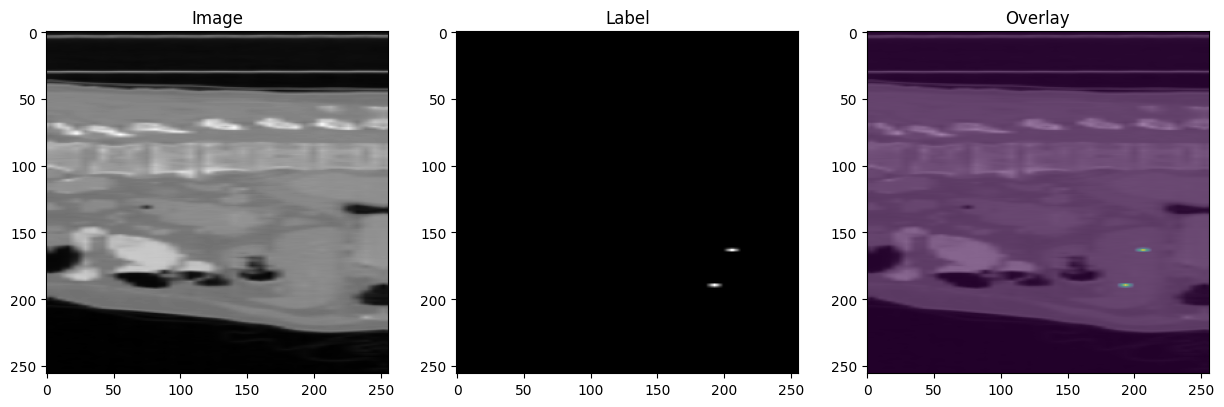

In [ ]:
# Function to visualize a random sample image and its label
def visualize_random_sample(images, labels):
    # Choose a random index
    idx = np.random.randint(0, len(images))

    # Extract the image and label for the chosen index
    image = images[idx]
    label = labels[idx]

    # Plotting the central slice for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image slice
    axes[0].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Image')

    # Plot label slice
    axes[1].imshow(label[label.shape[0] // 2, :, :], cmap='gray')
    axes[1].set_title('Label')

    # Plot overlay of label on image
    axes[2].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[2].imshow(label[label.shape[0] // 2, :, :], alpha=0.5, cmap='viridis')
    axes[2].set_title('Overlay')

    plt.show()

# Visualize a random sample
visualize_random_sample(train_images_normalized, train_labels_normalized)


## Noise Reduction for Images and Labels


In [ ]:
def denoise_images(images, labels):
    # Apply Gaussian blur for noise reduction to both images and labels
    images_denoised = gaussian_filter(images, sigma=1)
    labels_denoised = gaussian_filter(labels, sigma=1)

    return images_denoised, labels_denoised

# Denoise training and testing images and labels
train_images_denoised, train_labels_denoised = denoise_images(train_images_normalized, train_labels_normalized)
test_images_denoised, test_labels_denoised = denoise_images(test_images_normalized, test_labels_normalized)


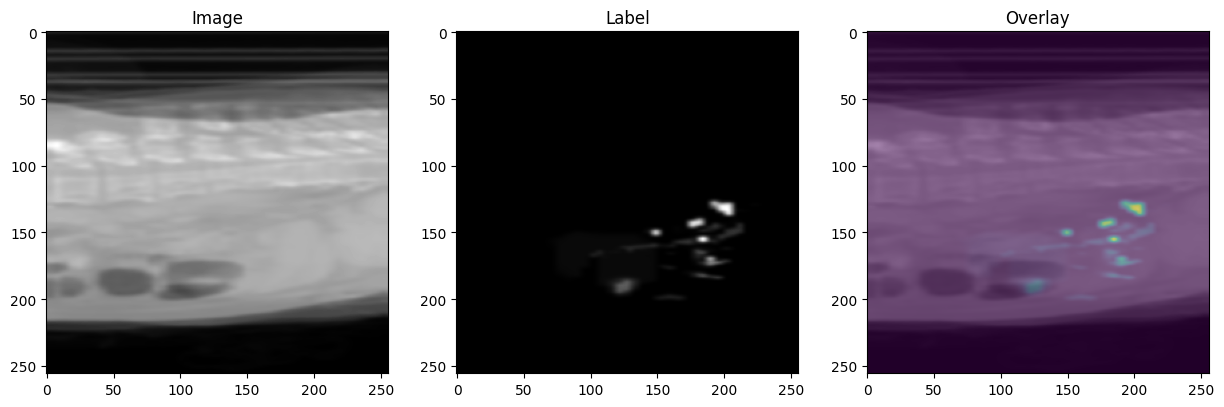

In [ ]:
# Function to visualize a random sample image and its label
def visualize_random_sample(images, labels):
    # Choose a random index
    idx = np.random.randint(0, len(images))

    # Extract the image and label for the chosen index
    image = images[idx]
    label = labels[idx]

    # Plotting the central slice for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image slice
    axes[0].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Image')

    # Plot label slice
    axes[1].imshow(label[label.shape[0] // 2, :, :], cmap='gray')
    axes[1].set_title('Label')

    # Plot overlay of label on image
    axes[2].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[2].imshow(label[label.shape[0] // 2, :, :], alpha=0.5, cmap='viridis')
    axes[2].set_title('Overlay')

    plt.show()

# Visualize a random sample
visualize_random_sample(train_images_denoised, train_labels_denoised)

In [ ]:
# Save denoised data
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/train_images_denoised.npy', train_images_denoised)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/train_labels_denoised.npy', train_labels_denoised)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/test_images_denoised.npy', test_images_denoised)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/test_labels_denoised.npy', test_labels_denoised)

**Resample Data**

In [ ]:
# Load denoised data from saved files
train_images_denoised = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/denoised_data/train_images_denoised.npy')
train_labels_denoised = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/denoised_data/train_labels_denoised.npy')
test_images_denoised = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/denoised_data/test_images_denoised.npy')
test_labels_denoised = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/denoised_data/test_labels_denoised.npy')


In [ ]:

target_shape = (256, 256, 256)  # Adjust target shape as needed
from scipy.ndimage import zoom

def resample_images(images, labels, target_shape):
    # Initialize empty lists to store resampled images and labels
    images_resampled = []
    labels_resampled = []

    # Calculate resampling factors
    factors = [target_shape[i] / images.shape[1:][i] for i in range(3)]

    # Loop over each 3D volume in the first dimension
    for i in range(images.shape[0]):
        # Resample images
        image_resampled = zoom(images[i], factors, mode='nearest')
        images_resampled.append(image_resampled)

        # Resample labels using the same factors
        label_resampled = zoom(labels[i], factors, mode='nearest')
        labels_resampled.append(label_resampled)

    return np.array(images_resampled), np.array(labels_resampled)

# Resample denoised training and testing images and labels
train_images_resampled, train_labels_resampled = resample_images(train_images_denoised, train_labels_denoised, target_shape)
test_images_resampled, test_labels_resampled = resample_images(test_images_denoised, test_labels_denoised, target_shape)


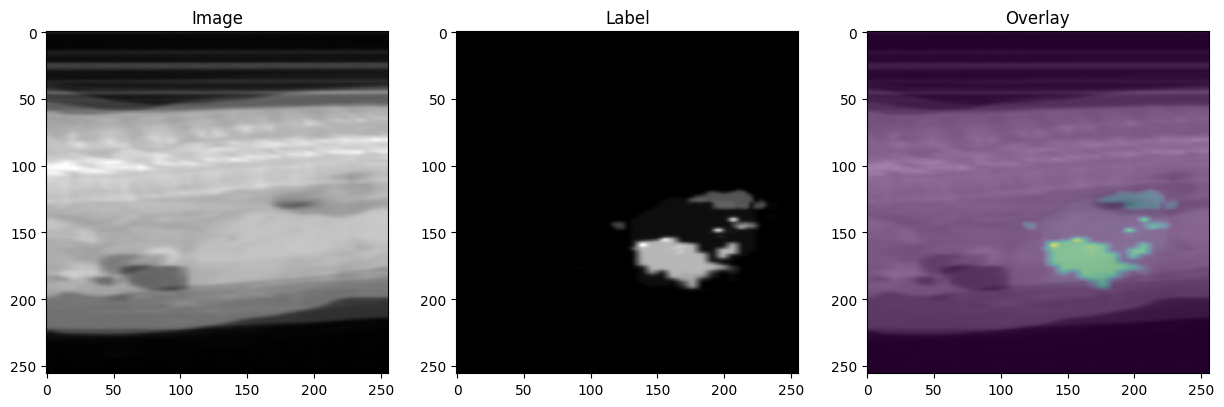

In [ ]:
# Function to visualize a random sample image and its label
def visualize_random_sample(images, labels):
    # Choose a random index
    idx = np.random.randint(0, len(images))

    # Extract the image and label for the chosen index
    image = images[idx]
    label = labels[idx]

    # Plotting the central slice for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image slice
    axes[0].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Image')

    # Plot label slice
    axes[1].imshow(label[label.shape[0] // 2, :, :], cmap='gray')
    axes[1].set_title('Label')

    # Plot overlay of label on image
    axes[2].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[2].imshow(label[label.shape[0] // 2, :, :], alpha=0.5, cmap='viridis')
    axes[2].set_title('Overlay')

    plt.show()

# Visualize a random sample
visualize_random_sample(train_images_resampled, train_labels_resampled)

In [ ]:
# Save resampled images and labels
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/train_images_resampled.npy', train_images_resampled)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/train_labels_resampled.npy', train_labels_resampled)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/test_images_resampled.npy', test_images_resampled)
np.save('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/test_labels_resampled.npy', test_labels_resampled)

## U-Net Model (Define) model 1

In [ ]:
def simplified_unet_model(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling3D(size=(2, 2, 2))(conv4)
    up5 = Conv3D(128, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=-1)
    conv5 = Conv3D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv3D(128, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling3D(size=(2, 2, 2))(conv5)
    up6 = Conv3D(64, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=-1)
    conv6 = Conv3D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv3D(64, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    up7 = Conv3D(32, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=-1)
    conv7 = Conv3D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv3D(32, 3, activation='relu', padding='same')(conv7)

    outputs = Conv3D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


## U-Net Model (Define) model 2

In [ ]:
# from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
# from tensorflow.keras.models import Model

# def simplified_unet_model(input_shape=(128, 128, 128, 1)):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv3D(16, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv3D(16, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

#     conv2 = Conv3D(32, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv3D(32, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

#     conv3 = Conv3D(64, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv3D(64, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

#     # Bottleneck
#     conv4 = Conv3D(128, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv3D(128, 3, activation='relu', padding='same')(conv4)

#     # Decoder
#     up5 = UpSampling3D(size=(2, 2, 2))(conv4)
#     up5 = Conv3D(64, 2, activation='relu', padding='same')(up5)
#     merge5 = concatenate([conv3, up5], axis=-1)
#     conv5 = Conv3D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = Conv3D(64, 3, activation='relu', padding='same')(conv5)

#     up6 = UpSampling3D(size=(2, 2, 2))(conv5)
#     up6 = Conv3D(32, 2, activation='relu', padding='same')(up6)
#     merge6 = concatenate([conv2, up6], axis=-1)
#     conv6 = Conv3D(32, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv3D(32, 3, activation='relu', padding='same')(conv6)

#     up7 = UpSampling3D(size=(2, 2, 2))(conv6)
#     up7 = Conv3D(16, 2, activation='relu', padding='same')(up7)
#     merge7 = concatenate([conv1, up7], axis=-1)
#     conv7 = Conv3D(16, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv3D(16, 3, activation='relu', padding='same')(conv7)

#     outputs = Conv3D(1, 1, activation='sigmoid')(conv7)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model


## Define Dice Loss Function

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


## Create Model and Compile

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
model = simplified_unet_model(input_shape=(128, 128, 128, 1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])


## Define Model Checkpoint and Save Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/cnn_vessels/checkpoints/unet_checkpoint_{epoch:02d}.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')


## Load Resised after Resampled Data and Train the Model with Callbacks

In [ ]:
# Load resampled images and labels
train_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_images_resized.npy')
train_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_labels_resized.npy')
test_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_images_resized.npy')
test_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_labels_resized.npy')

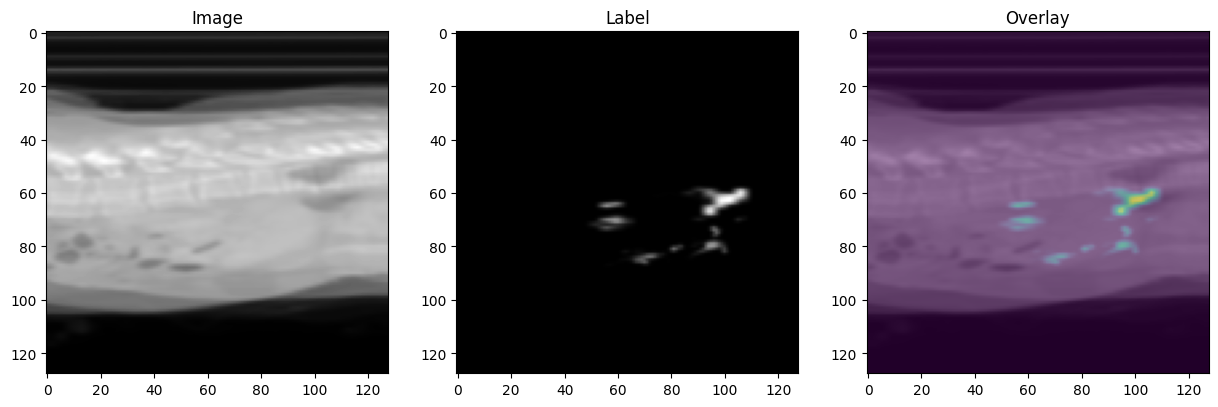

In [ ]:
# Function to visualize a random sample image and its label
def visualize_random_sample(images, labels):
    # Choose a random index
    idx = np.random.randint(0, len(images))

    # Extract the image and label for the chosen index
    image = images[idx]
    label = labels[idx]

    # Plotting the central slice for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image slice
    axes[0].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Image')

    # Plot label slice
    axes[1].imshow(label[label.shape[0] // 2, :, :], cmap='gray')
    axes[1].set_title('Label')

    # Plot overlay of label on image
    axes[2].imshow(image[image.shape[0] // 2, :, :], cmap='gray')
    axes[2].imshow(label[label.shape[0] // 2, :, :], alpha=0.5, cmap='viridis')
    axes[2].set_title('Overlay')

    plt.show()

# Visualize a random sample
visualize_random_sample(test_images_resized, test_labels_resized)

**testing the images from the nnunet preprocessed**

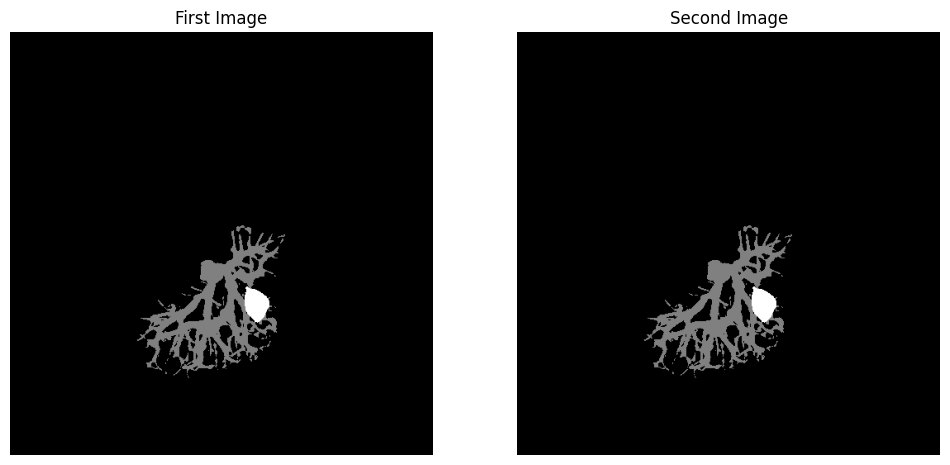

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the .nii.gz files
nii_img1 = nib.load('/content/drive/MyDrive/vessels/nnUNet/nnunetv2/nnUNet_preprocessed_test/Dataset101_HepVes/gt_segmentations/hepaticvessel_011_0000_0000_0000_0000.nii.gz')
nii_img2 = nib.load('/content/drive/MyDrive/vessels/nnUNet/nnunetv2/nnUNet_raw/Dataset101_HepVes/labelsTr/hepaticvessel_011_0000_0000_0000_0000.nii.gz')

# Get the image data
img_data1 = nii_img1.get_fdata()
img_data2 = nii_img2.get_fdata()

# Define the axis along which to create the maximum intensity projection (MIP) (e.g., Z-axis)
axis = 2

# Create the MIPs
mip1 = np.max(img_data1, axis=axis)
mip2 = np.max(img_data2, axis=axis)

# Plot the MIPs side by side
plt.figure(figsize=(12, 6))

# Plot the first MIP
plt.subplot(1, 2, 1)
plt.imshow(mip1, cmap='gray')
plt.title('First Image')
plt.axis('off')

# Plot the second MIP
plt.subplot(1, 2, 2)
plt.imshow(mip2, cmap='gray')
plt.title('Second Image')
plt.axis('off')

plt.show()


## Augmentation

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of the width
    height_shift_range=0.1, # Random vertical shift by up to 10% of the height
    shear_range=0.2,         # Shear intensity (shear angle in radians)
    zoom_range=0.2,          # Random zoom by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True      # Randomly flip images vertically
)

# Load resampled images and labels
train_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_images_resized.npy')
train_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_labels_resized.npy')

# Define a function to apply data augmentation and save augmented images and labels to separate files
def apply_augmentation(images, labels, num_augmented_images=1000, batch_size=32, save_images_path='augmented_images.npy', save_labels_path='augmented_labels.npy'):
    # Create a generator for augmented data
    aug_generator = datagen.flow(images, labels, batch_size=batch_size)

    augmented_images = []
    augmented_labels = []

    # Generate augmented images and labels
    for _ in range(num_augmented_images // batch_size):
        batch_images, batch_labels = next(aug_generator)
        augmented_images.extend(batch_images)
        augmented_labels.extend(batch_labels)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Save augmented images and labels to separate .npy files
    np.save(save_images_path, augmented_images)
    np.save(save_labels_path, augmented_labels)

    print(f'Saved {num_augmented_images} augmented images to {save_images_path}')
    print(f'Saved {num_augmented_images} augmented labels to {save_labels_path}')

# Apply data augmentation and save augmented data
apply_augmentation(train_images_resized, train_labels_resized, save_images_path='/content/drive/MyDrive/cnn_vessels/augmented_images.npy', save_labels_path='/content/drive/MyDrive/cnn_vessels/augmented_labels.npy')


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (260, 128, 128, 128) (128 channels).
  warnings.warn(


Saved 1000 augmented images to /content/drive/MyDrive/cnn_vessels/augmented_images.npy
Saved 1000 augmented labels to /content/drive/MyDrive/cnn_vessels/augmented_labels.npy


**First model Training**

In [ ]:
# Train the model with resampled data
history = model.fit(train_images_resized[..., np.newaxis], train_labels_resized[..., np.newaxis],
                    validation_data=(test_images_resized[..., np.newaxis], test_labels_resized[..., np.newaxis]),
                    epochs=10, batch_size=4, callbacks=[model_checkpoint])

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: -0.0153 - dice_coef: 1.0153

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 78s 778ms/step - loss: -0.0153 - dice_coef: 1.0153 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 2/10
65/65 [==============================] - 34s 531ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 3/10
65/65 [==============================] - 34s 530ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 4/10
65/65 [==============================] - 35s 532ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 5/10
65/65 [==============================] - 35s 532ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 6/10
65/65 [==============================] - 34s 531ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_dice_coef: 1.0556
Epoch 7/10
65/65 [==============================] - 35s 532ms/step - loss: -0.0680 - dice_coef: 1.0680 - val_loss: -0.0556 - val_

In [ ]:
# import numpy as np
# from skimage.transform import resize

# # Load resampled images and labels
# train_images_resampled = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/train_images_resampled.npy')
# train_labels_resampled = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/train_labels_resampled.npy')
# test_images_resampled = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/test_images_resampled.npy')
# test_labels_resampled = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resampled_data/test_labels_resampled.npy')

# # Resize images and labels
# train_images_resized = resize(train_images_resampled, (train_images_resampled.shape[0], 128, 128, 128), anti_aliasing=True)
# train_labels_resized = resize(train_labels_resampled, (train_labels_resampled.shape[0], 128, 128, 128), anti_aliasing=False)
# test_images_resized = resize(test_images_resampled, (test_images_resampled.shape[0], 128, 128, 128), anti_aliasing=True)
# test_labels_resized = resize(test_labels_resampled, (test_labels_resampled.shape[0], 128, 128, 128), anti_aliasing=False)


In [ ]:
# # Define paths to save the resized data
# save_folder = '/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/'

# # Save resized images and labels
# np.save(save_folder + 'train_images_resized.npy', train_images_resized)
# np.save(save_folder + 'train_labels_resized.npy', train_labels_resized)
# np.save(save_folder + 'test_images_resized.npy', test_images_resized)
# np.save(save_folder + 'test_labels_resized.npy', test_labels_resized)


## Save the Final Model

In [ ]:
model.save("/content/drive/MyDrive/cnn_vessels/unet_model_final2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction

1/1 [==============================] - 0s 297ms/step


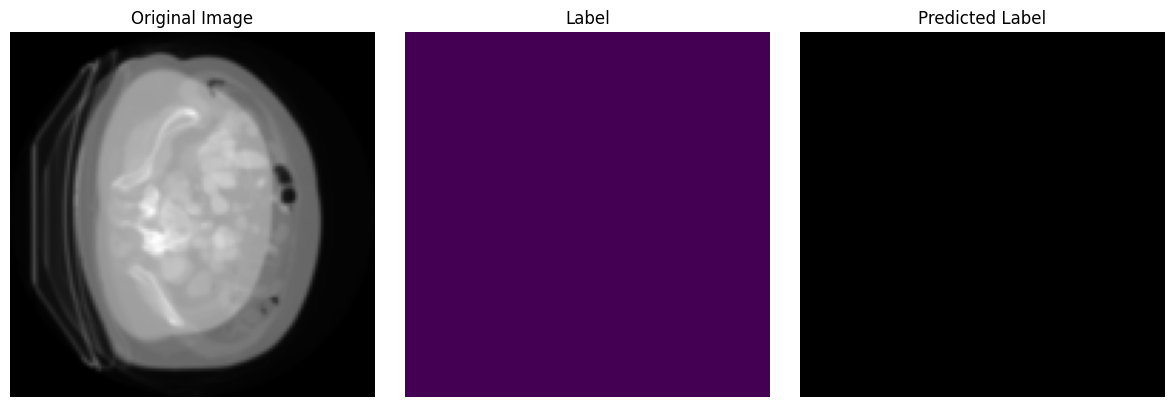

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define the custom loss function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load the trained model
model = load_model("/content/drive/MyDrive/cnn_vessels/unet_model_final2.h5", custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# Load test data
test_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_images_resized.npy')
test_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_labels_resized.npy')

# Select a single sample
index = 0  # Choose the index of the sample you want to predict
test_image = test_images_resized[index]
test_label = test_labels_resized[index]

# Predict on the selected sample
predicted_label = model.predict(test_image[np.newaxis, ..., np.newaxis])[0, ..., 0]

# Plot the original image, ground truth label, and predicted label
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image[..., 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_label[..., 0], cmap='viridis')
plt.title('Label')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_label[..., 0], cmap='gray')
plt.title('Predicted Label')
plt.axis('off')

plt.tight_layout()
plt.show()


**Define Model 3 for the new shape after augmentation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Define a modified UNet model with added batch normalization and dropout
def modified_unet_model(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv3D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(16, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(32, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    # Bottleneck
    conv3 = Conv3D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(64, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    # Decoder
    up4 = UpSampling3D(size=(2, 2, 2))(conv3)
    up4 = Conv3D(32, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=-1)
    conv4 = Conv3D(32, 3, activation='relu', padding='same')(merge4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(32, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling3D(size=(2, 2, 2))(conv4)
    up5 = Conv3D(16, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=-1)
    conv5 = Conv3D(16, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(16, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    outputs = Conv3D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define custom loss function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load resampled images and labels
train_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/augmented_images.npy')
train_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/augmented_labels.npy')
test_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_images_resized.npy')
test_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_labels_resized.npy')




**Define Model 4 for the new shape after augmentation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Define a modified UNet model with added batch normalization, dropout, and more convolutional layers
def modified_unet_model(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up5 = UpSampling3D(size=(2, 2, 2))(conv4)
    up5 = Conv3D(128, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=-1)
    conv5 = Conv3D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling3D(size=(2, 2, 2))(conv5)
    up6 = Conv3D(64, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=-1)
    conv6 = Conv3D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    up7 = Conv3D(32, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=-1)
    conv7 = Conv3D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    outputs = Conv3D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define custom loss function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load resampled images and labels
train_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/augmented_images.npy')
train_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/augmented_labels.npy')
test_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_images_resized.npy')
test_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/test_labels_resized.npy')


In [ ]:
# Create and compile the model
model = modified_unet_model(input_shape=(128, 128, 128, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/cnn_vessels/checkpoints/unet2_checkpoint_{epoch:02d}.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with resampled data
history = model.fit(train_images_resized[..., np.newaxis], train_labels_resized[..., np.newaxis],
                    validation_data=(test_images_resized[..., np.newaxis], test_labels_resized[..., np.newaxis]),
                    epochs=10, batch_size=4, callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10


**model 3 (unet_model_final_agment)**

In [ ]:
model.save("/content/drive/MyDrive/cnn_vessels/unet_model_final_agment.h5")

**prediction of the new model (unet_model_final3)**

1/1 [==============================] - 0s 300ms/step


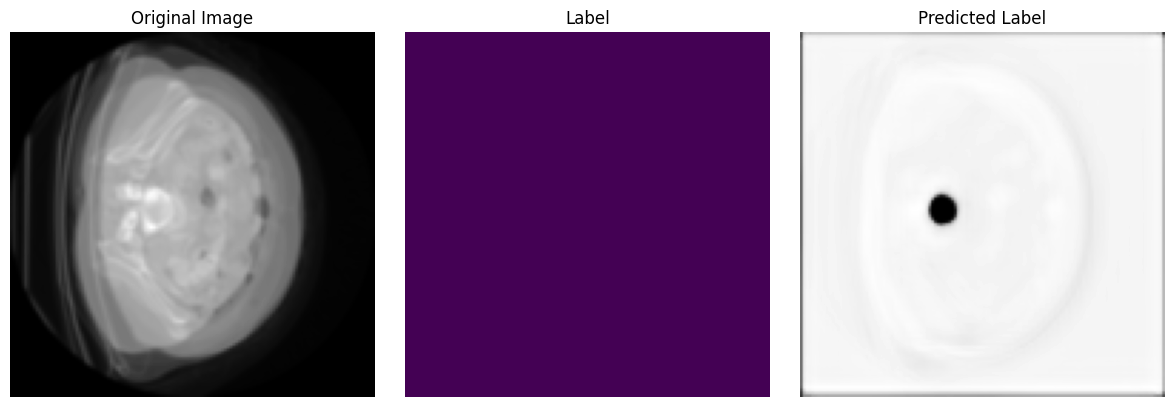

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define the custom loss function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load the trained model
model = load_model("/content/drive/MyDrive/cnn_vessels/unet_model_final3.h5", custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# Load test data
test_images_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_images_resized.npy')
test_labels_resized = np.load('/content/drive/MyDrive/cnn_vessels/preprocessed/resized_data/train_labels_resized.npy')

# Select a random sample
index = np.random.randint(0, len(test_images_resized))
test_image = test_images_resized[index]
test_label = test_labels_resized[index]

# Predict on the selected sample
predicted_label = model.predict(test_image[np.newaxis, ..., np.newaxis])[0, ..., 0]

# Plot the original image, ground truth label, and predicted label
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image[..., 0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_label[..., 0], cmap='viridis')
plt.title('Label')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_label[..., 0], cmap='gray')
plt.title('Predicted Label')
plt.axis('off')

plt.tight_layout()
plt.show()
